#Segmentador de caracteres

* Problema: Nem sempre é simples digitarmos algo que está escrito em um papel, uma tela. Tirando uma foto, podemos manter aquele registro salvo, mas para compartilharmos o conteúdo que interessa, ou para manipularmos o texto de acordo com nosso próprio interesse, é necessário fazermos essa conversão de imagem para texto. A segmentação das letras na imagem é um passo importante para tal objetivo.

* Solução: Presumindo que as letras de um texto vêm todas num formato (fonte) pré-estabelecido e possuem todas a mesma textura, pretendemos segmentar por borda, formas que correspondam a letras de uma fonte específica, a princípio para uma posterior análise de um classificador como uma random forest ou rede neural, muito utilizada para este fim.

Para isso utilizaremos a transformada de fourier para que possamos operar sobre frequência realçando as bordas. Utilizaremos os filtros de passa alta com esse intuito. Após termos as bordas realçadas identificaremos os limites dos caracteres para segmentar a imagem.

In [3]:
import cv2 as cv
import numpy as np
from google.colab.patches import cv2_imshow as cv_imshow

img_c1 = cv.imread("prancha.jpg", 0)
print(img_c1.shape)
# cv_imshow(img_c1)

(720, 1280)


(<matplotlib.axes._subplots.AxesSubplot at 0x7ff766bccc50>,
 Text(0.5, 1.0, 'Imagem processada'))

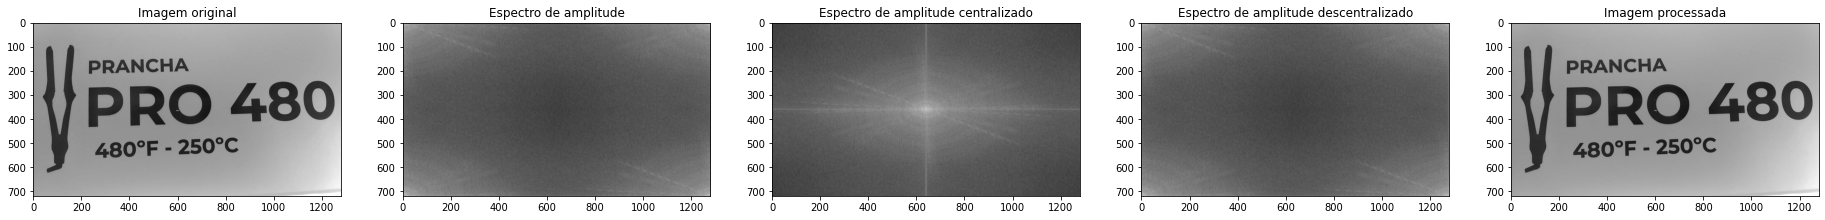

In [4]:
import matplotlib.pyplot as plt

img_c2 = np.fft.fft2(img_c1)
img_c3 = np.fft.fftshift(img_c2)
img_c4 = np.fft.ifftshift(img_c3)
img_c5 = np.fft.ifft2(img_c4)

plt.figure(figsize=(6.4*5, 4.8*5), constrained_layout=False)

plt.subplot(151), plt.imshow(img_c1, "gray"), plt.title("Imagem original")
plt.subplot(152), plt.imshow(np.log(1+np.abs(img_c2)), "gray"), plt.title("Espectro de amplitude")
plt.subplot(153), plt.imshow(np.log(1+np.abs(img_c3)), "gray"), plt.title("Espectro de amplitude centralizado")
plt.subplot(154), plt.imshow(np.log(1+np.abs(img_c4)), "gray"), plt.title("Espectro de amplitude descentralizado")
plt.subplot(155), plt.imshow(np.abs(img_c5), "gray"), plt.title("Imagem processada")

# imgArray = img.ravel()
# N = len(imgArray)

# yf = scipy.fft.fft(imgArray)
# xf = scipy.fft.fftfreq(N, 1)

# plt.figure(figsize=(22,6))
# plt.plot(xf, numpy.abs(yf))
# plt.yscale('log')
# plt.grid()
# plt.show()

Acima nós temos a visualização do gráfico da amplitude do espectro da imagem. A área branca mostra a alta potência da frequência e os cantos representam baixas frequências, ou seja, temos que há alta energia em frequências baixas, o que acontece na maioria das imagens.

Para facilitar a aplicação do filtro, realizamos a rotação na imagem, trazendo os cantos para o centro (centralização).

As imagens 4 e 5 mostram as operações inversas, retornando à imagem original.

Com a transformada em mãos, vamos a construção dos filtros que iremos utilizar.

In [5]:
import math
def distance(point1,point2):
    return math.sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2)

def idealFilterHP(D0,imgShape):
    base = np.ones(imgShape[:2])
    rows, cols = imgShape[:2]
    center = (rows/2,cols/2)
    for x in range(cols):
        for y in range(rows):
            if distance((y,x),center) < D0:
                base[y,x] = 0
    return base

def laplacianFilter(imgShape):
    base = np.ones(imgShape[:2])
    rows, cols = imgShape[:2]
    center = (rows/2,cols/2)
    for x in range(cols):
        for y in range(rows):
              base[y,x] = -4*(math.pi**2)*(distance((y, x), center)**2)
    return base

Como nosso objetivo é segmentar caracteres, buscaremos atenuar outras frequências e ressaltar as que estão relacionadas com as bordas. Por isso escolhemos utilizar filtros passa alta, ou seja que passam frequências altas e retem frequências baixas.

O filtro ideal de passa alta e o filtro laplaciano nos darão esse resultado.

Pelo teorema da convolução temos que f(t)*h(t) = fourierInversa(F(w).H(w)), portanto geramos nossa matriz de H(w) que multiplicará nossa matriz da transformada da nossa imagem F(w) e com a inversa dessa multiplicação, teremos nossa imagem filtrada.

(<matplotlib.image.AxesImage at 0x7ff75fa3a490>,
 Text(0.5, 1.0, 'Ideal High Pass'))

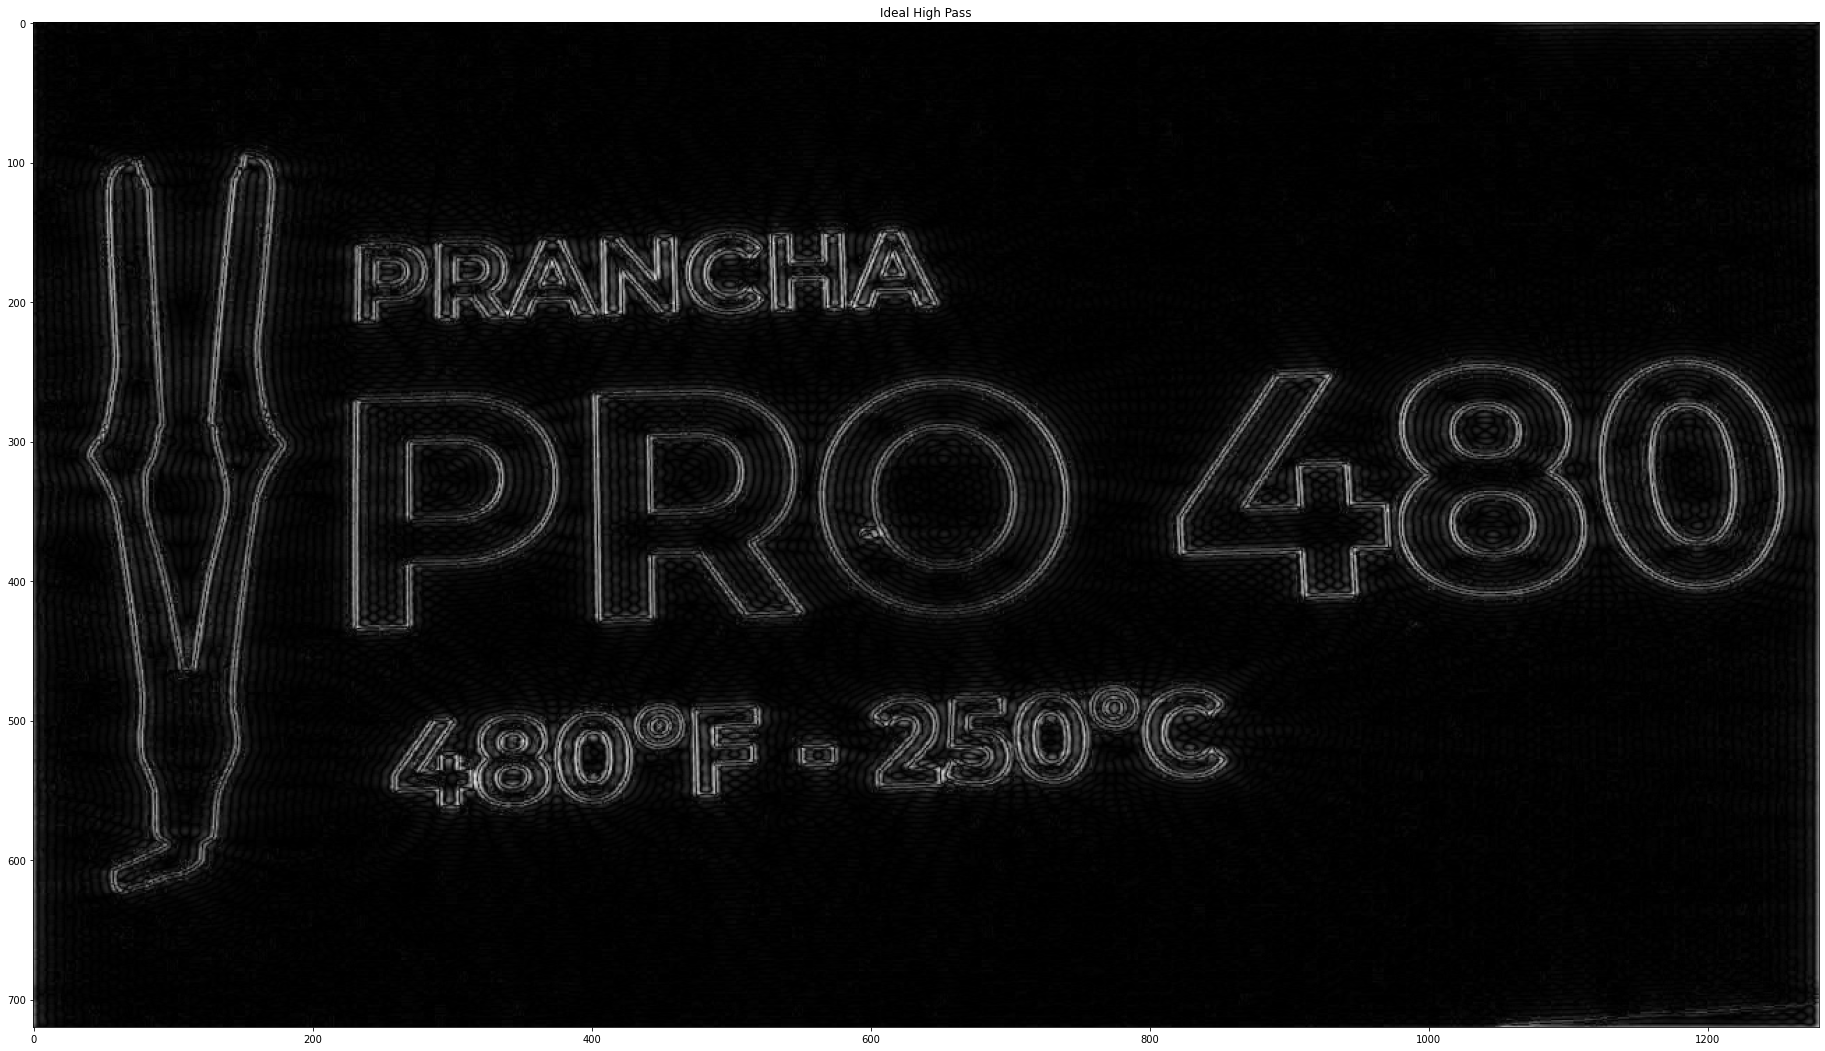

In [133]:
# Usando filtro passa alta ideal
plt.figure(figsize=(6.4*5, 4.8*5), constrained_layout=False)
center = img_c3

HighPassCenter = center * idealFilterHP(100, img_c1.shape)
HighPass = np.fft.ifftshift(HighPassCenter)
inverse_HighPass = np.fft.ifft2(HighPass)
plt.imshow(np.abs(inverse_HighPass), "gray"), plt.title("Ideal High Pass")

(<matplotlib.image.AxesImage at 0x7ff76581df50>, Text(0.5, 1.0, 'Laplacian'))

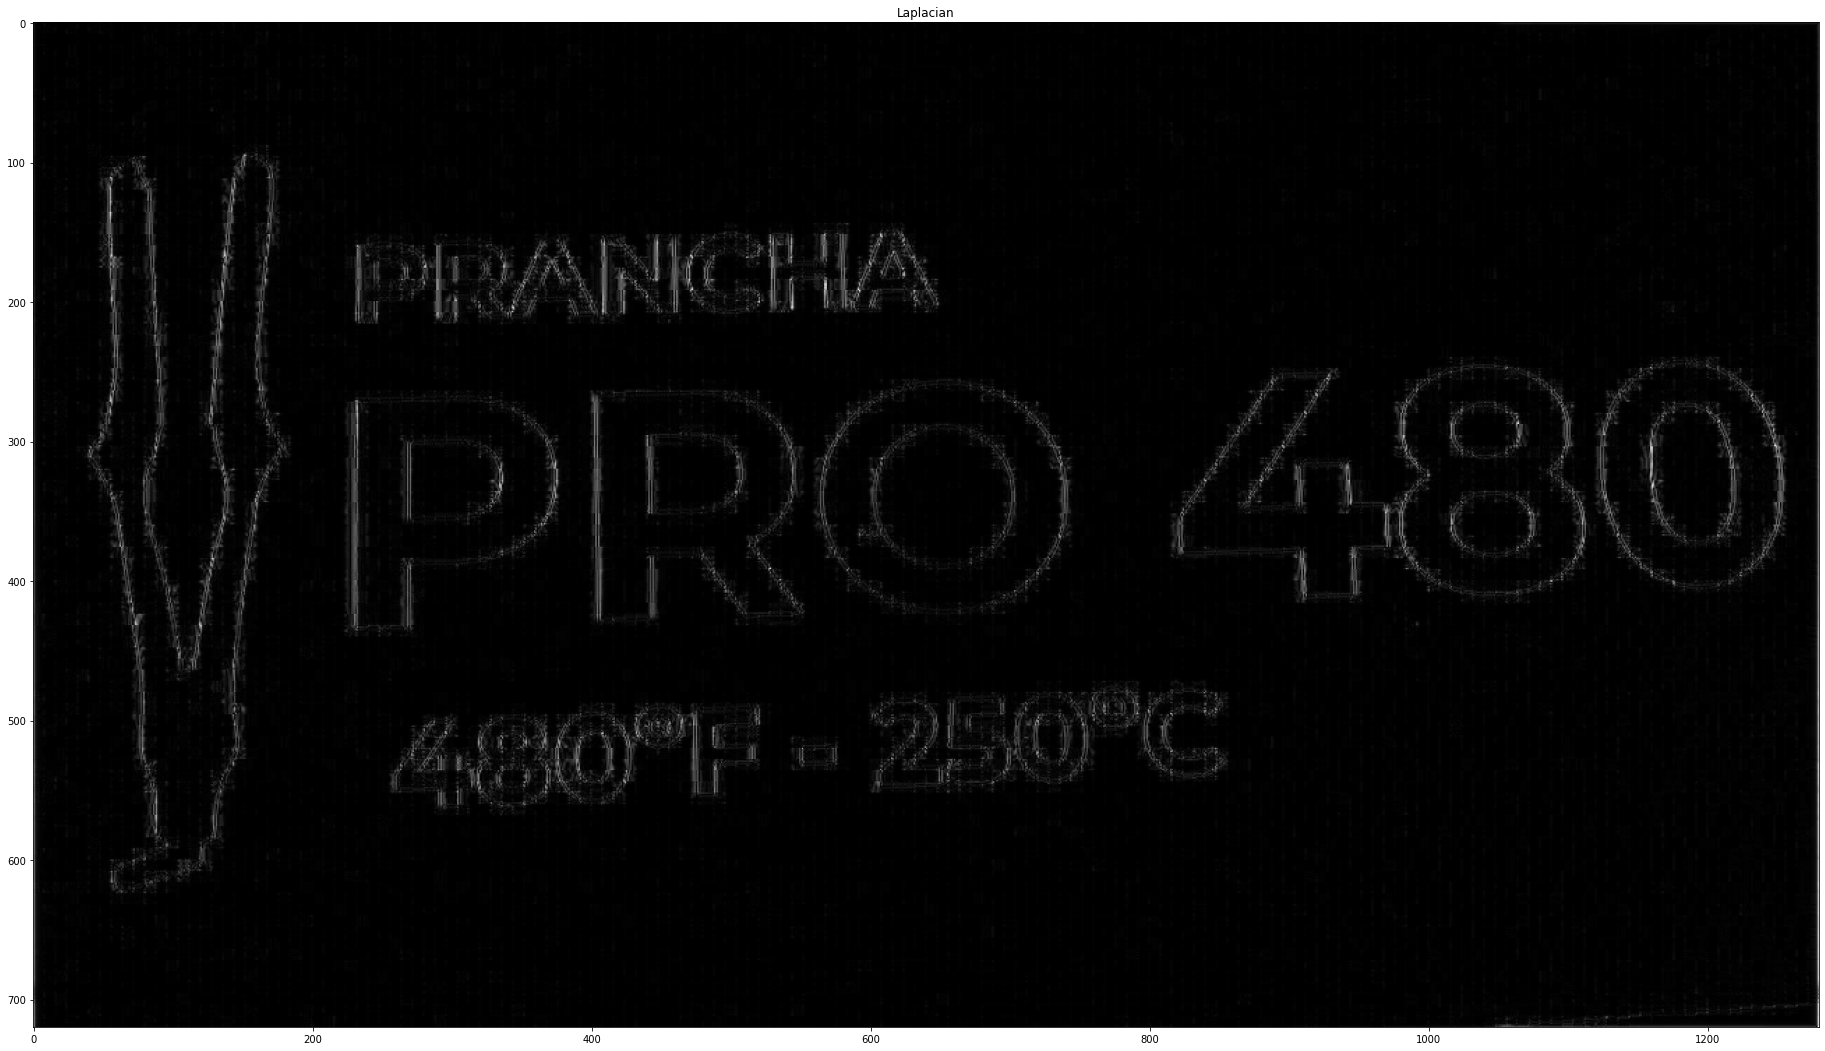

In [16]:
# Usando filtro laplaciano
plt.figure(figsize=(6.4*5, 4.8*5), constrained_layout=False)
center = img_c3

laplacianCenter = center * laplacianFilter(img_c1.shape)
laplacian = np.fft.ifftshift(laplacianCenter)
inverse_laplacian = np.fft.ifft2(laplacian)
plt.imshow(np.abs(inverse_laplacian), "gray"), plt.title("Laplacian")
# cv_imshow(np.abs(inverse_laplacian))

Como obtivemos um resultado mais limpo com o laplaciano, utilizaremos apenas ele a partir de agora.

Fazendo a soma dos valores da matriz da imagem no eixo x, conseguimos vizualizar os limites inicial e final do texto.

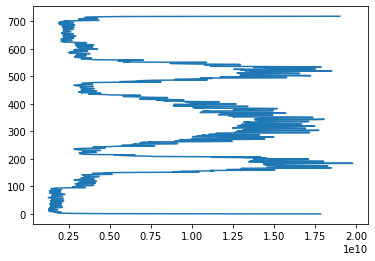

In [9]:
rows, cols = img_c1.shape
sumRows = np.sum(np.abs(inverse_laplacian), axis=1)
plt.plot(sumRows, np.arange(rows))
# print(sumCols.shape)

Pelo formato do gráfico podemos traduzir para o algoritmo a informação de onde começam e onde terminam as linhas.

In [95]:
# Encontra o começo da linha de texto/Caracter
def findStart(mean, sum, start=0):
  for i in range(start, rows):
    if sum[i] > mean:
      return i
  return rows

# Encontra o final da linha de texto/Caracter
def findStop(mean, sum, start=0):
  for i in range(start, rows):
    if (sum[i] < mean) & (i < rows):
      return i+1
  return rows

In [ ]:
Com o código abaixo, segmentamos trechos da imagem na horizontal que possuem valores relativamente altos.

In [123]:
lines = []
mean = sumRows.mean()*1/2
startLine = 0
stopLine = 0

while(stopLine < rows):
  startLine = findStart(mean, sumRows, stopLine)
  stopLine = findStop(mean, sumRows, startLine)
  if(stopLine-1-startLine > 0.025*rows):
    lines.append(inverse_laplacian[startLine:stopLine-1])

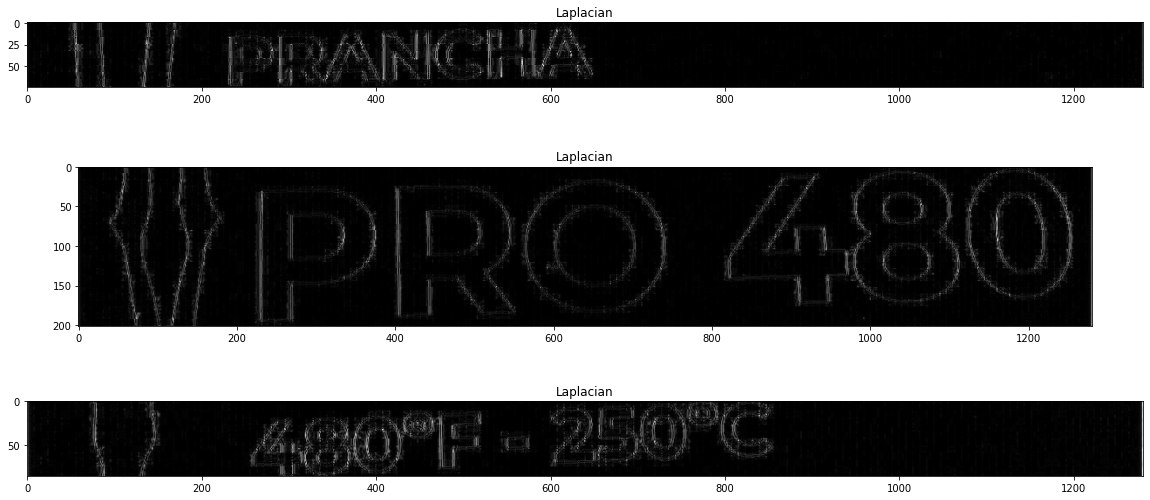

In [127]:
plt.figure(figsize=(20, 10))
for i in range(len(lines)):
  plt.subplot(3, 1, i+1), plt.imshow(np.abs(lines[i]), "gray"), plt.title("Laplacian")

Agora que temos as linhas segmentadas, nosso objetivo passa a ser segmentar os caracteres de cada linha.

Exibindo a soma dos valores da imagem no eixo y podemos observar as fronteiras entre os caracteres. Aqui são bem menos espaçadas que entre as linhas, o que nos imputa um desafio maior.

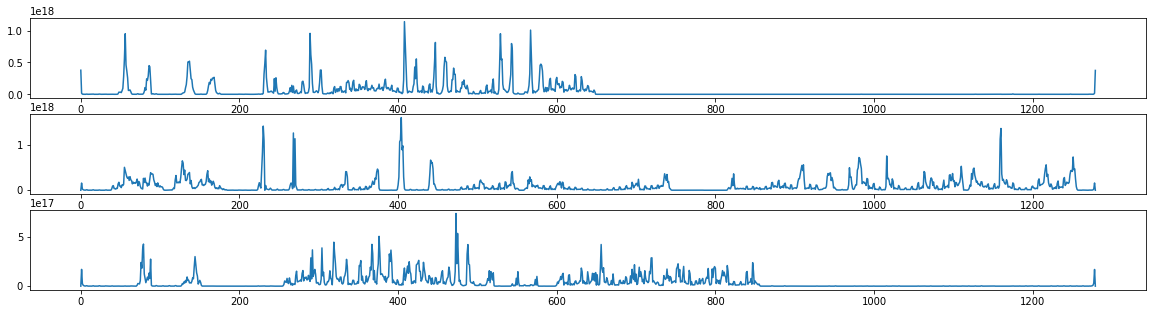

In [125]:
plt.figure(figsize=(20,5))
rows, cols = img_c1.shape
for i in range(len(lines)):
  sumCols = np.sum(np.abs(lines[i]**2), axis=0)
  for j in range(cols):
    if sumCols[j] > 2*10**18:
      sumCols[j] = 0
  plt.subplot(len(lines), 1, i+1), plt.plot(np.arange(cols), sumCols)
# print(sumCols.shape)

Faremos o mesmo que fizemos com as linhas

obs: Infelizmente não conseguimos fazer funcionar daqui em diante a tempo

In [113]:
caracters = []
mean = sumCols.mean()*1/2
startColumn = 0
stopColumn = 0

while(stopColumn < cols):
  startColumn = findStart(mean, sumCols, stopColumn)
  stopColumn = findStop(mean, sumCols, startColumn)
  if(stopColumn-startColumn > 0.05*cols):
    caracters.append(lines[1][:][startColumn:stopColumn-1])

KeyboardInterrupt: ignored

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  


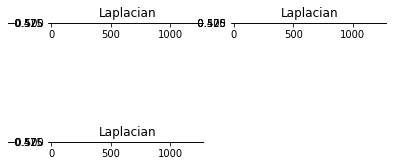

In [112]:
for i in range(len(caracters)):
  plt.subplot(2, len(caracters)/2 + len(caracters)%2, i+1), plt.imshow(np.abs(caracters[i]), "gray"), plt.title("Laplacian")

(Text(0.5, 1.0, 'Sobel Y'),
 ([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>))

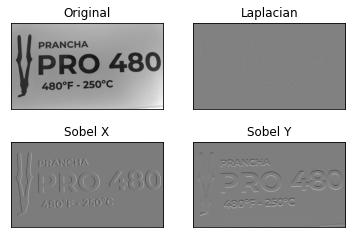

In [200]:
# laplacian = cv.Laplacian(img_c1,cv.CV_64F)
# sobelx = cv.Sobel(img_c1,cv.CV_64F,1,0,ksize=5)
# sobely = cv.Sobel(img_c1,cv.CV_64F,0,1,ksize=5)
# plt.subplot(2,2,1),plt.imshow(img_c1,cmap = 'gray')
# plt.title('Original'), plt.xticks([]), plt.yticks([])
# plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
# plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
# plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
# plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
# plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
# plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])